In [1]:
import h5py
import os

import openmc
from helpers import *

In [2]:
# read sinbad data
sinbad_file = h5py.File('sinbad_data.h5', 'r')

In [3]:

_groups = ['onaxis_group1', 'onaxis_group2', 'offaxis']
_cells_group1 = [135, 158, 181, 204, 602, 239, 262, 285, 308, 331, 363, 386, 398]
_cells_group2 = [605, 606, 607, 608, 609, 610, 611, 612, 602, 603, 604]
_cells_offaxis = [135, 158, 181, 204, 605, 606, 607, 608, 609, 610, 611, 612, 602, 603, 604]

_foil_volume = .1 * 1.8**2/4 * np.pi
_volumes_group1 = np.concatenate((np.ones(5), np.ones(4)*2, np.ones(4)*3)) * _foil_volume
_volumes_group2 = np.ones(11) * _foil_volume
_volumes_offaxis = np.ones(15) * _foil_volume

_cells_heating = [239, 262, 285, 308, 331, 363, 386, 398, 500, 507, 514, 521]
_ev2gy = 1.60217733e-16  # dose conversion factor from eV and Gy


def get_openmc_tally(simulation_type:str, statepoint_file:str, tally_name:str):

    try:
        os.chdir(simulation_type)
        sp =  openmc.StatePoint(statepoint_file)
        tally = sp.get_tally(name=tally_name).get_pandas_dataframe()
        os.chdir('..')
        return tally
    except FileNotFoundError:
        None

def postprocess_openmc_foils(tally_dataframe, foil_group:str):
    
    if foil_group not in _groups:
        raise ValueError("Invalid foil_group. Expected one of: %s" % _groups)
    
    df = tally_dataframe.loc[(tally_dataframe['particle'] == 'neutron')]
    
    if foil_group == _groups[0]:
        df = df[df['cell'].isin(_cells_group1)]
        df['mean'] = df['mean'] / _volumes_group1
        df['std. dev.'] = df['std. dev.'] / _volumes_group1
    elif foil_group == _groups[1]:
        df = df[df['cell'].isin(_cells_group2)]
        df['mean'] = df['mean'] / _volumes_group2
        df['std. dev.'] = df['std. dev.'] / _volumes_group2
    elif foil_group == _groups[2]:
        df = df[df['cell'].isin(_cells_offaxis)]
        df['mean'] = df['mean'] / _volumes_offaxis
        df['std. dev.'] = df['std. dev.'] / _volumes_offaxis
    
    return df

def postprocess_openmc_heating(tally_dataframe):

    # extract qtld cs, ce, cp coefficients
    qtld_coeffs = sinbad_file['heating/qtld_coefficients/table']
    ce = np.array(qtld_coeffs['Ce'])
    cn = np.array(qtld_coeffs['Cn'])
    cp = np.array(qtld_coeffs['Cp'])

    omc_qn = []
    omc_qp = []
    for c in _cells_heating:
        c_heating = tally_dataframe.loc[tally_dataframe['cell'] == c]

        if c in (239, 262, 285, 308):
            vol = _foil_volume * 2
        elif c in (331, 363, 386, 398):
            vol = _foil_volume * 3
        elif c in (500, 507, 514, 521):
            vol = 4/3 * np.pi * .8**3
        
        if c in (507, 521):
            density = 8.94  # g/cm3 - copper
        else:
            density = 7.89  # g/cm3 - aisi361

        c_heating_mean = np.array(c_heating['mean']) / vol / density * _ev2gy
        n_heating_mean = c_heating_mean[0]
        p_heating_mean = sum(c_heating_mean[1:])

        c_heating_stddev = np.array(c_heating['std. dev.']) / vol / density *_ev2gy
        n_heating_stddev = c_heating_stddev[0]
        p_heating_stddev = sum(c_heating_stddev[1:])

        omc_qn.append([n_heating_mean, n_heating_stddev])
        omc_qp.append([p_heating_mean, p_heating_stddev])

    omc_qn = np.array(omc_qn).T.reshape(2,12)
    omc_qp = np.array(omc_qp).T.reshape(2,12)

    omc_qtld = [omc_qn[i] * cn * ce + qp * cp for i,qp in enumerate(omc_qp)]

    tally_dataframe = tally_dataframe.drop(columns=['particle', 'nuclide']).drop_duplicates('cell')
    tally_dataframe['mean'] = omc_qtld[0]
    tally_dataframe['std. dev.'] = omc_qtld[1]

    return tally_dataframe
    

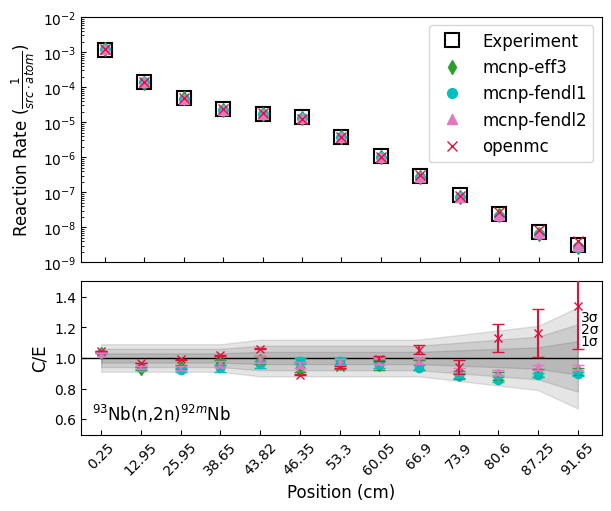

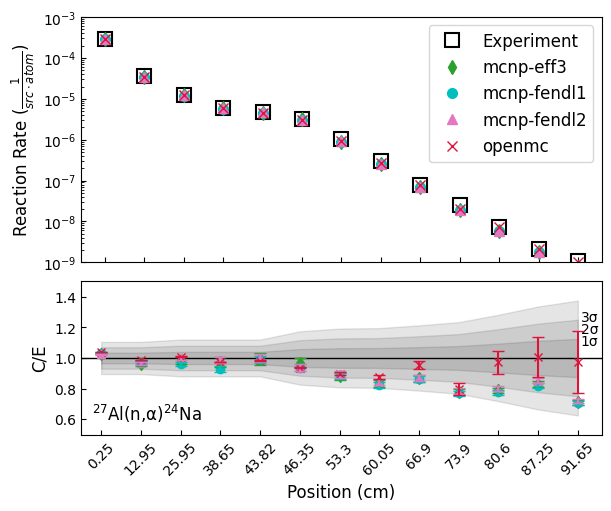

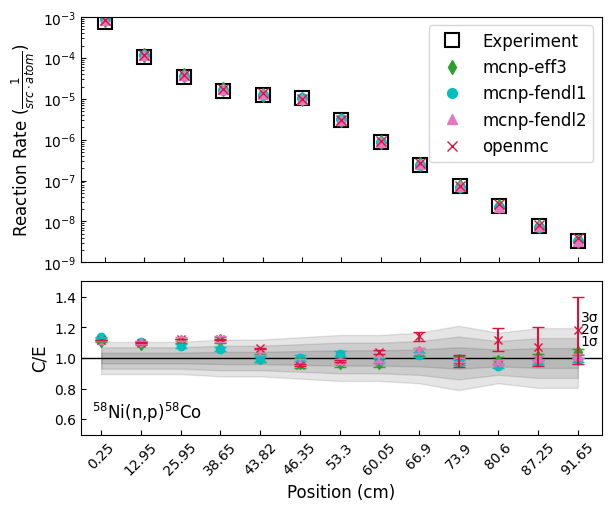

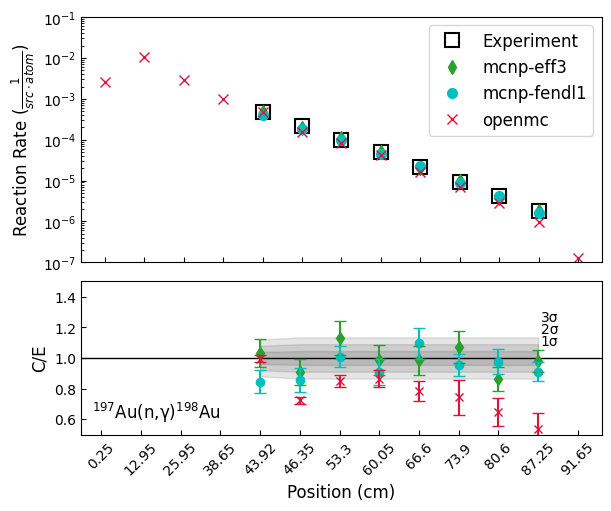

In [4]:
# initialization
path = 'reaction_rates_onaxis/group_1/'
foil_list = ['nb93', 'al27', 'ni58', 'au197']
reaction_labels = ['$^{93}$Nb(n,2n)$^{92m}$Nb', '$^{27}$Al(n,\u03B1)$^{24}$Na', '$^{58}$Ni(n,p)$^{58}$Co', '$^{197}$Au(n,\u03B3)$^{198}$Au']
ylabel = r'Reaction Rate $(\frac{1}{src \cdot atom})$'

for i,foil in enumerate(foil_list):
    measured = sinbad_file[path + f'measured/{foil}/table']
    mcnp_eff3 = sinbad_file[path + f'mcnp-eff3/{foil}/table']
    mcnp_fendl1 = sinbad_file[path + f'mcnp-fendl1/{foil}/table']
    try:
        mcnp_fendl2 = sinbad_file[path + f'mcnp-fendl2/{foil}/table']
    except:
        mcnp_fendl2 = None

    # read openmc results from its statepoint file
    openmc_1 = get_openmc_tally('reaction_rates_onaxis', 'statepoint.100.h5', f'{foil}_irdff_rr')
    openmc_1 = postprocess_openmc_foils(openmc_1, 'onaxis_group1')

    # plot
    dtype_label = reaction_labels[i]
    foils_onaxis_group1 = VisualizeResults()  # the plot has always to be initialized like this
    foils_onaxis_group1.add_measured_data(measured, ylabel, dtype_label)  # measured data have always to be plotted
    foils_onaxis_group1.add_computed_data(mcnp_eff3, 'd', 'tab:green', 'mcnp-eff3')  # one can add as many computed data as preferred
    foils_onaxis_group1.add_computed_data(mcnp_fendl1, 'o', 'c', 'mcnp-fendl1')
    foils_onaxis_group1.add_computed_data(mcnp_fendl2, '^', 'tab:pink', 'mcnp-fendl2')
    foils_onaxis_group1.add_computed_data(openmc_1, 'x', 'crimson', 'openmc')

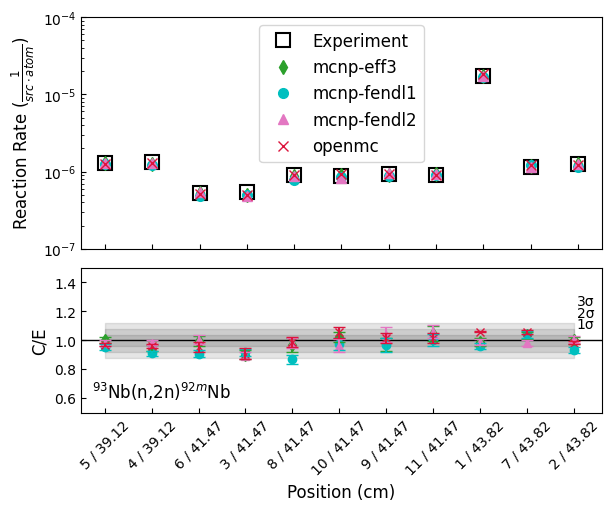

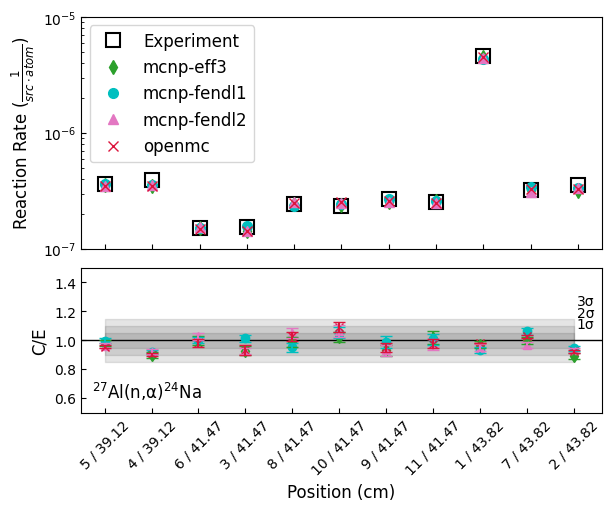

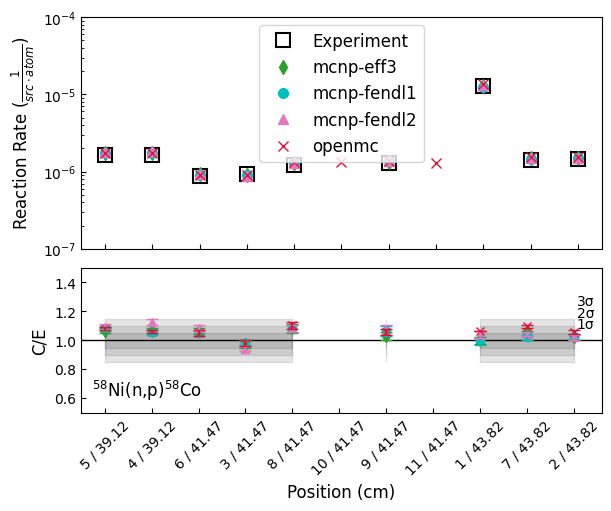

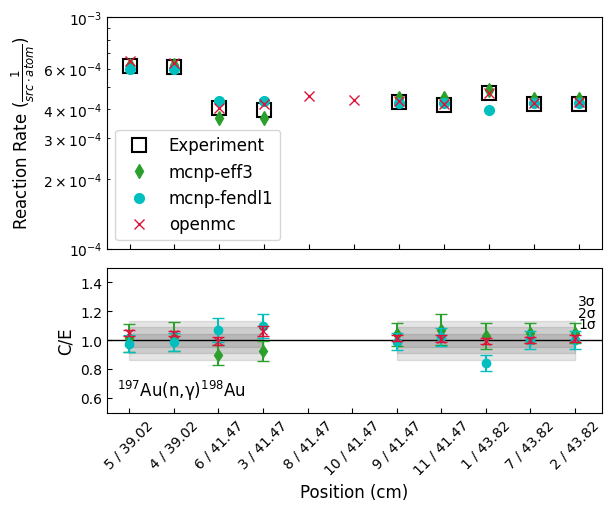

In [5]:
# initialization
path = 'reaction_rates_onaxis/group_2/'
foil_list = ['nb93', 'al27', 'ni58', 'au197']
reaction_labels = ['$^{93}$Nb(n,2n)$^{92m}$Nb', '$^{27}$Al(n,\u03B1)$^{24}$Na', '$^{58}$Ni(n,p)$^{58}$Co', '$^{197}$Au(n,\u03B3)$^{198}$Au']
ylabel = r'Reaction Rate $(\frac{1}{src \cdot atom})$'

for i,foil in enumerate(foil_list):
    measured = sinbad_file[path + f'measured/{foil}/table']
    mcnp_eff3 = sinbad_file[path + f'mcnp-eff3/{foil}/table']
    mcnp_fendl1 = sinbad_file[path + f'mcnp-fendl1/{foil}/table']
    try:
        mcnp_fendl2 = sinbad_file[path + f'mcnp-fendl2/{foil}/table']
    except:
        mcnp_fendl2 = None

    # read openmc results from its statepoint file
    openmc_1 = get_openmc_tally('reaction_rates_onaxis', 'statepoint.100.h5', f'{foil}_irdff_rr')
    openmc_1 = postprocess_openmc_foils(openmc_1, 'onaxis_group2')
    
    # plot
    dtype_label = reaction_labels[i]
    foils_onaxis_group2 = VisualizeResults()  # the plot has always to be initialized like this
    foils_onaxis_group2.add_measured_data(measured, ylabel, dtype_label)  # measured data have always to be plotted
    foils_onaxis_group2.add_computed_data(mcnp_eff3, 'd', 'tab:green', 'mcnp-eff3')  # one can add as many computed data as preferred
    foils_onaxis_group2.add_computed_data(mcnp_fendl1, 'o', 'c', 'mcnp-fendl1')
    foils_onaxis_group2.add_computed_data(mcnp_fendl2, '^', 'tab:pink', 'mcnp-fendl2')
    foils_onaxis_group2.add_computed_data(openmc_1, 'x', 'crimson', 'openmc')

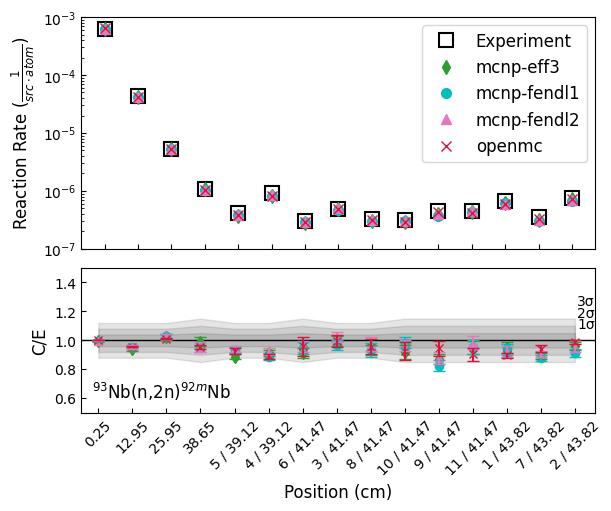

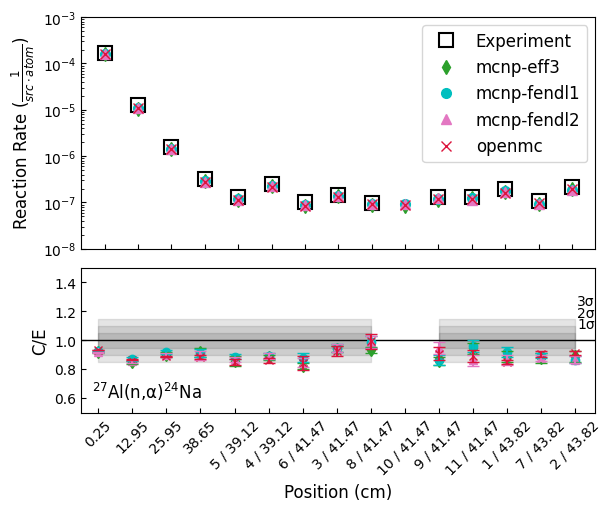

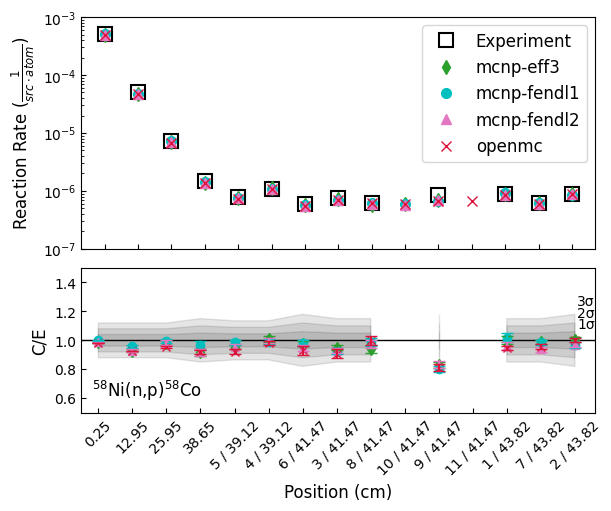

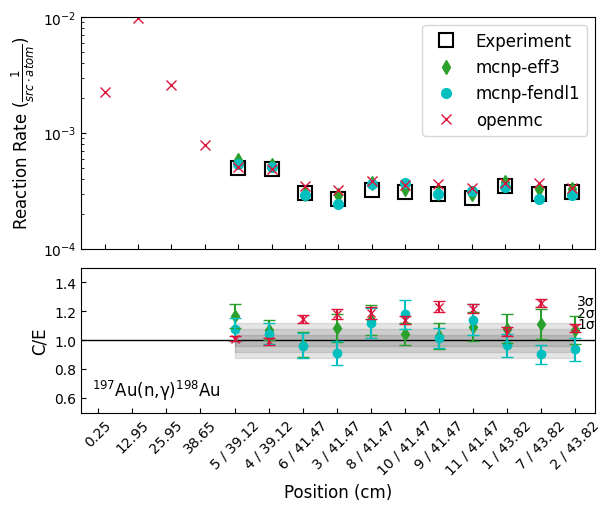

In [6]:
# initialization
path = 'reaction_rates_offaxis/'
foil_list = ['nb93', 'al27', 'ni58', 'au197']
reaction_labels = ['$^{93}$Nb(n,2n)$^{92m}$Nb', '$^{27}$Al(n,\u03B1)$^{24}$Na', '$^{58}$Ni(n,p)$^{58}$Co', '$^{197}$Au(n,\u03B3)$^{198}$Au']
ylabel = r'Reaction Rate $(\frac{1}{src \cdot atom})$'

for i,foil in enumerate(foil_list):

    # read measured and mcnp results from sinbad file
    measured = sinbad_file[path + f'measured/{foil}/table']
    mcnp_eff3 = sinbad_file[path + f'mcnp-eff3/{foil}/table']
    mcnp_fendl1 = sinbad_file[path + f'mcnp-fendl1/{foil}/table']
    try:
        mcnp_fendl2 = sinbad_file[path + f'mcnp-fendl2/{foil}/table']
    except:
        mcnp_fendl2 = None

    # read openmc results from its statepoint file
    openmc_1 = get_openmc_tally('reaction_rates_offaxis', 'statepoint.100.h5', f'{foil}_irdff_rr')
    openmc_1 = postprocess_openmc_foils(openmc_1, 'offaxis')
    
    # plot
    dtype_label = reaction_labels[i]
    foils_offaxis = VisualizeResults()  # the plot has always to be initialized like this
    foils_offaxis.add_measured_data(measured, ylabel, dtype_label)  # measured data have always to be plotted
    foils_offaxis.add_computed_data(mcnp_eff3, 'd', 'tab:green', 'mcnp-eff3')  # one can add as many computed data as preferred
    foils_offaxis.add_computed_data(mcnp_fendl1, 'o', 'c', 'mcnp-fendl1')
    foils_offaxis.add_computed_data(mcnp_fendl2, '^', 'tab:pink', 'mcnp-fendl2')
    foils_offaxis.add_computed_data(openmc_1, 'x', 'crimson', 'openmc')

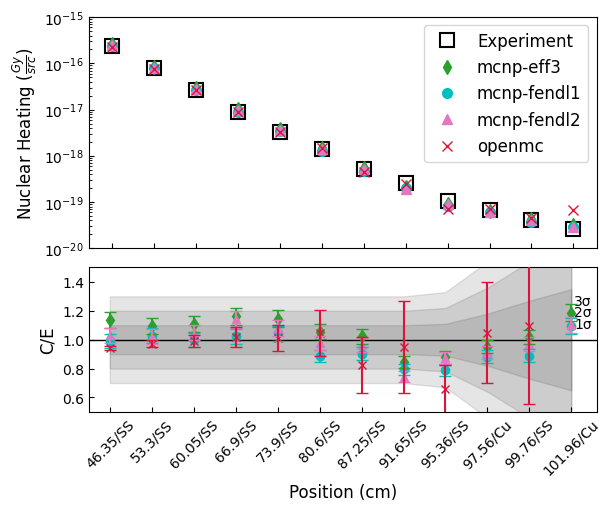

In [7]:
# initialization
path = 'heating/'
ylabel = r'Nuclear Heating $(\frac{Gy}{src})$'

measured = sinbad_file[path + f'measured/table']
mcnp_eff3 = sinbad_file[path + f'mcnp-eff3/table']
mcnp_fendl1 = sinbad_file[path + f'mcnp-fendl1/table']
mcnp_fendl2 = sinbad_file[path + f'mcnp-fendl2/table']

qtld_coeffs = sinbad_file['heating/qtld_coefficients/table']
openmc_1 = get_openmc_tally('heating', 'statepoint.100.h5', 'heating_dose')
openmc_1 = postprocess_openmc_heating(openmc_1, qtld_coeffs)

nuclear_heating = VisualizeResults()  # the plot has always to be initialized like this
nuclear_heating.add_measured_data(measured, ylabel, dtype_label='')  # measured data have always to be plotted
nuclear_heating.add_computed_data(mcnp_eff3, 'd', 'tab:green', 'mcnp-eff3')  # one can add as many computed data as preferred
nuclear_heating.add_computed_data(mcnp_fendl1, 'o', 'c', 'mcnp-fendl1')
nuclear_heating.add_computed_data(mcnp_fendl2, '^', 'tab:pink', 'mcnp-fendl2')
nuclear_heating.add_computed_data(openmc_1, 'x', 'crimson', 'openmc')